In [5]:

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import tqdm
#import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import timm
import torcheval 
import wandb
import torchvision
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import seaborn as sns
from albumentations.pytorch import ToTensorV2
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import psutil

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


# select Device

In [6]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
DATA_DIRECTORY = os.path.join(os.getcwd(),"data")
torch.cuda.empty_cache()

In [11]:
class Config():

    BASE_DIR = os.path.join(os.getcwd() , 'data')
    train_df = pd.read_csv(BASE_DIR  +  '/train.csv')
    TRAIN_VAL_SPLIT_SIZE = 0.2
    TRAIN_BATCH_SIZE = 128
    VAL_BATCH_SIZE = 128

    LR_MAX = 1e-4 
    NUM_EPOCHS = 18
    TIM_NUM_CLASS = 1408
    NORMALIZE_TARGET = "log_transform"
    RANDOM_NUMBER = 42
    NUM_FLODS  = 5
    NUM_CLASSES = 6
    TRAITS_NAME = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]
    FOLD = 0 # Which fold to set as validation data
    IMAGE_SIZE =128
    TARGET_IMAGE_SIZE  =128
    T_MAX =        9
    LR_MODE = "step" # LR scheduler mode from one of "cos", "step", "exp"
    torch.manual_seed(RANDOM_NUMBER)
    INCLUDE_EXTRA_FEATURES = True
    EXTRA_FEATURES_NORMALIZATION = "min_max_normalization"
    WEIGHT_DECAY = 0.01
    
    
    # use XGBBOOST to find prominant features
    EXTRA_COLOUMN = [
    'WORLDCLIM_BIO1_annual_mean_temperature',
'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
'WORLDCLIM_BIO15_precipitation_seasonality',
'WORLDCLIM_BIO4_temperature_seasonality',
'SOIL_ocd_100.200cm_mean_0.01_deg',
'WORLDCLIM_BIO12_annual_precipitation',
'WORLDCLIM_BIO7_temperature_annual_range',
'SOIL_cec_0.5cm_mean_0.01_deg',
'SOIL_nitrogen_0.5cm_mean_0.01_deg',
'SOIL_ocd_60.100cm_mean_0.01_deg',
'SOIL_ocd_30.60cm_mean_0.01_deg',
'SOIL_clay_100.200cm_mean_0.01_deg',
'SOIL_soc_100.200cm_mean_0.01_deg',
'SOIL_nitrogen_100.200cm_mean_0.01_deg',
'SOIL_cec_100.200cm_mean_0.01_deg',
'SOIL_clay_15.30cm_mean_0.01_deg',
'SOIL_soc_60.100cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
'SOIL_nitrogen_30.60cm_mean_0.01_deg',
'SOIL_clay_5.15cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
'SOIL_ocd_0.5cm_mean_0.01_deg',
'SOIL_ocd_5.15cm_mean_0.01_deg',
'SOIL_cfvo_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
'SOIL_cfvo_30.60cm_mean_0.01_deg',
'SOIL_cfvo_0.5cm_mean_0.01_deg',
'SOIL_soc_15.30cm_mean_0.01_deg',
'SOIL_nitrogen_15.30cm_mean_0.01_deg',
'SOIL_nitrogen_5.15cm_mean_0.01_deg',
'SOIL_clay_0.5cm_mean_0.01_deg',
'SOIL_nitrogen_60.100cm_mean_0.01_deg',
'SOIL_soc_0.5cm_mean_0.01_deg',
'SOIL_ocd_15.30cm_mean_0.01_deg',
'SOIL_ocs_0.30cm_mean_0.01_deg',
'SOIL_clay_30.60cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
'SOIL_cfvo_15.30cm_mean_0.01_deg',
'SOIL_silt_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
'SOIL_soc_30.60cm_mean_0.01_deg',
'SOIL_cfvo_5.15cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
'SOIL_silt_0.5cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
'SOIL_sand_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12'
]
  
CONFIG = Config()



In [8]:

from sklearn.preprocessing import StandardScaler , MinMaxScaler
SCALAR = None

def create_val_train_dataset(BASE_DIR,train_split_size):
    global SCALAR
    df = pd.read_csv(BASE_DIR  +  '/train.csv')
    if CONFIG.INCLUDE_EXTRA_FEATURES :
        df = df[["id"] +CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME]
        df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training datafram
    else :  
        df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df = df[["id"] + ["image_path"] ]
    
    # do the normalization
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        if CONFIG.EXTRA_FEATURES_NORMALIZATION == "StandardScaler":
            SCALAR = StandardScaler()
            # standardize the dataset ( tabular dataset )
            SCALAR.fit(df[CONFIG.EXTRA_COLOUMN])
            df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])
        elif CONFIG.EXTRA_FEATURES_NORMALIZATION == "min_max_normalization":
            SCALAR = MinMaxScaler()
            # standardize the dataset ( tabular dataset )
            SCALAR.fit(df[CONFIG.EXTRA_COLOUMN])
            df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])
    
    
    
    
    # skf = StratifiedKFold(n_splits=NUM_FLODS, shuffle=True, random_state=42)

    # # Create separate bin for each traits
    # for i, trait in enumerate(TRAITS_NAME):

    #     # Determine the bin edges dynamically based on the distribution of traits
    #     bin_edges = np.percentile(df[trait], np.linspace(0, 100, NUM_FLODS + 1))
    #     df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

    # # Concatenate the bins into a final bin
    # df["final_bin"] = (
    #     df[[f"bin_{i}" for i in range(NUM_CLASSES)]]
    #     .astype(str)
    #     .agg("".join, axis=1)
    # )

    # # Perform the stratified split using final bin
    # df = df.reset_index(drop=True)
    # for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    #     df.loc[valid_idx, "fold"] = fold
    # sample_df = df.copy()
    # train_df = sample_df[sample_df.fold != FOLD]
    # val_df = sample_df[sample_df.fold == FOLD]

    
    train_df , val_df = train_test_split(df,test_size=train_split_size,shuffle=True)
    

    print(f"before removing the outliers Num Train: {len(train_df)} | Num Valid: {len(val_df)}")
    # upper_quantiles = train_df[CONFIG.TRAITS_NAME].quantile(0.98)
    # retained_flag = (train_df[CONFIG.TRAITS_NAME] < upper_quantiles).all(axis= 1) & (train_df[CONFIG.TRAITS_NAME] > 0).all(axis=1)
    # train_df = train_df[retained_flag]
    train_df = train_df[(np.abs(stats.zscore(np.log10(train_df[CONFIG.TRAITS_NAME]))<3).all(axis=1)  )]
    train_df.reset_index(drop=True , inplace  = True)
    val_df.reset_index(drop = True , inplace = True)
    print(f"after removing the outliers Num Train: {len(train_df)} | Num Valid: {len(val_df)}")

        
    return  train_df , val_df



def create_test_dataset(BASE_DIR):
    global SCALAR
    df = pd.read_csv(BASE_DIR  +  '/test.csv')
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        #print(df.columns)
        df = df[["id"] +CONFIG.EXTRA_COLOUMN]
        df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])   
    else :
        df = df[["id"] +CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME]
        df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df = df[["id"] + ["image_path"] ]
    return df

train_df , val_df = create_val_train_dataset(CONFIG.BASE_DIR,CONFIG.TRAIN_VAL_SPLIT_SIZE)
test_df = create_test_dataset(CONFIG.BASE_DIR)



# some hyper parameter for lr scheduler
CONFIG.N_TRAIN_SAMPLES = len(train_df)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.TRAIN_BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.NUM_EPOCHS + 1

before removing the outliers Num Train: 34690 | Num Valid: 8673
after removing the outliers Num Train: 31707 | Num Valid: 8673


/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

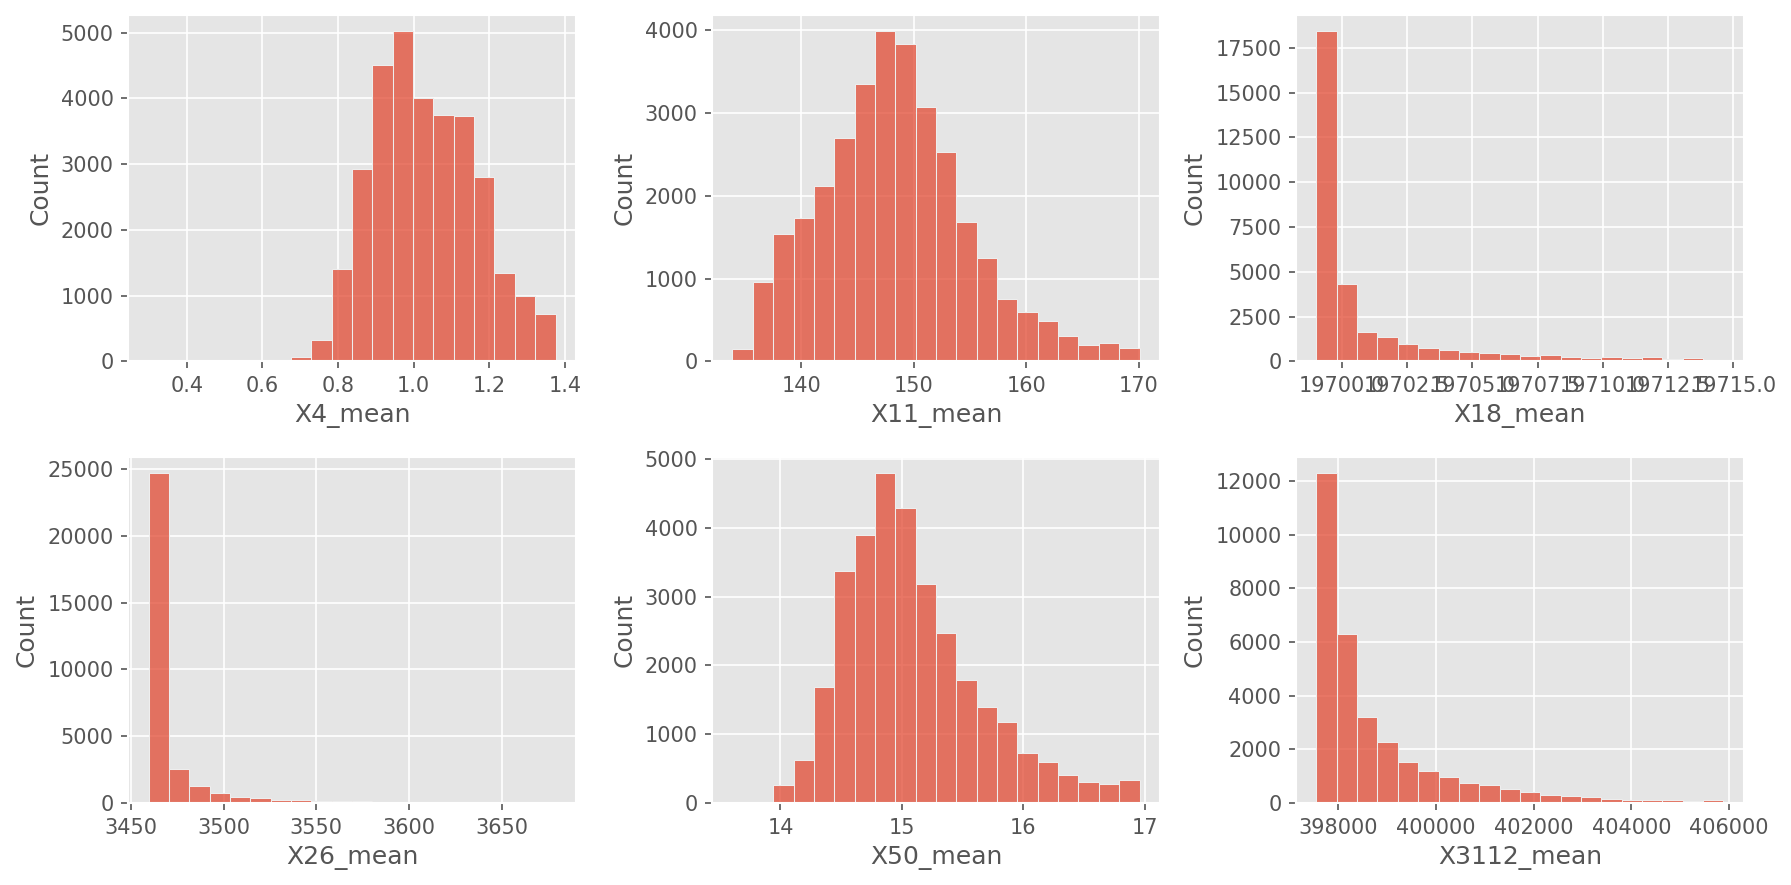

In [89]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(CONFIG.TRAITS_NAME):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=train_df, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()

# DATALOADER 

In [100]:
class NormalizeTarget():
    def __init__(self,type_transform ):
        self.transform = type_transform
        self.mean = 0
        self.std = 0
        self.mean_tensor = 0
        self.std_tensor = 0
        
    def normalize(self,df):
        if self.transform == "log_transform":
            mean = np.log10(df).mean()
            std = np.log10(df).std()
            min =  np.log10(df).min()
            max = np.log10(df).max()
            
            self.min  = min
            self.max = max
            
            self.mean = mean
            self.std = std
            
            self.min_tensor = torch.Tensor(self.min.values).to(DEVICE)
            self.max_tensor = torch.Tensor(self.max.values).to(DEVICE)
            
            self.mean_tensor = torch.Tensor(self.mean.values).to(DEVICE)
            self.std_tensor = torch.Tensor(self.std.values).to(DEVICE)
            
            tf = (np.log10(df) - self.min)/(self.max - self.min)
        elif self.transform == "log_transform_mean_std": 
            tf = (np.log10(df) - self.mean)/(self.std) 
        elif self.transform == None:
            tf = df
        return tf 
    def denormalize(self,df):
        if self.mean is None or self.std is None :
            raise Exception("mean and/std is not defined ")
        if self.transform  == "log_transform":
            df_denormalize =10**((df*(self.max - self.min)) + self.min )
            return df_denormalize
        if self.transform  =="log_transform_mean_std":
            df_denormalize =10**((df*self.std) + self.mean )
            return df_denormalize
        elif self.transform == None:
            df_denormalize = df
            return df_denormalize
        
    def denormalize_tensor(self,batch) :
        if self.mean_tensor is None or self.std_tensor is None :
            raise Exception("mean and/std is not defined ")
        if self.transform == "log_transform":
            df_denormalize =10**((batch*(self.max_tensor - self.min_tensor)) + self.min_tensor )
        elif self.transform == "log_transform_mean_std":
            df_denormalize =10**((batch*self.std_tensor) + self.mean_tensor )
        elif self.transform == None:
            df_denormalize = batch
        return df_denormalize
NormalizeTarget_obj = NormalizeTarget(CONFIG.NORMALIZE_TARGET)

In [106]:
class data_loader( Dataset ):
    def __init__(self,df , is_val = False):
        self.df = df.copy()
        self.is_val = is_val
        if CONFIG.NORMALIZE_TARGET == None:
            pass
        else:
            if not is_val :
                self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]] = NormalizeTarget_obj.normalize(self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]])
        
        
        
        self.train_transform  = A.Compose([
            #A.CLAHE(p=0.1),
            #A.RandomRotate90(p=0.1),
            #A.Transpose(p=0.4),
            #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
            #A.Blur(blur_limit=3,p=0.1),
            #A.OpticalDistortion(p=0.1),
            #A.GridDistortion(p=0.3),
            #A.HueSaturationValue(p=0.3),
            A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_LINEAR,p=0.8),
            A.ToFloat(),
            A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
            ToTensorV2(),
            ])
        
        self.val_transform = A.Compose([
                A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_CUBIC),
                A.ToFloat(),
                    A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
                    ToTensorV2(),
        ])
        self.extra_params = CONFIG.INCLUDE_EXTRA_FEATURES
        self.extra_coloumns = CONFIG.EXTRA_COLOUMN
    
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self , index):
        row = self.df.iloc[index]
        image = plt.imread(row["image_path"])
        #image = np.copy(image)
        traits = row[CONFIG.TRAITS_NAME].values.astype(np.float32)
        traits = torch.tensor(traits,dtype=torch.float32)
        if not self.is_val:
            image = self.train_transform(image = image)["image"]
            #image = torch.permute(image  )
        else:
            image = self.val_transform(image = image)["image"]
            
        if self.extra_params:
            extras = row[self.extra_coloumns].values.astype(np.float32)
            return image , traits  , torch.tensor(extras,dtype=torch.float32)
        return  image , traits



train_dataset = data_loader(train_df, is_val = False )
val_dataset  = data_loader(val_df,   is_val = True)    

train_dataloader = DataLoader(train_dataset , batch_size = CONFIG.TRAIN_BATCH_SIZE , shuffle=True, num_workers=psutil.cpu_count() )
val_dataloader = DataLoader(val_dataset , batch_size =  CONFIG.VAL_BATCH_SIZE , shuffle=False, num_workers=psutil.cpu_count() )


# Define Model

# Define Loss Metric for the Model and MISC

In [ ]:
# optimizer
import torcheval.metrics
import torcheval.metrics.regression


optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

# lr scheduler
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )
    
    
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count
        
MSE = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
R2 = torcheval.metrics.regression.R2Score(num_regressors=len(CONFIG.TRAITS_NAME) , multioutput="uniform_average").to(DEVICE)
LOSS = AverageMeter()
TARGET_TRAITS_MEAN = torch.tensor(train_df[CONFIG.TRAITS_NAME].mean().values).to(DEVICE)        # target mean accross the training dataset
EPS = torch.tensor([1e-6]).to('cuda')


# just to check if r2 loss is also decreasing 
def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - TARGET_TRAITS_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

LOSS_FN = nn.SmoothL1Loss() # r2_loss
LR_SCHEDULER = get_lr_scheduler(optimizer)

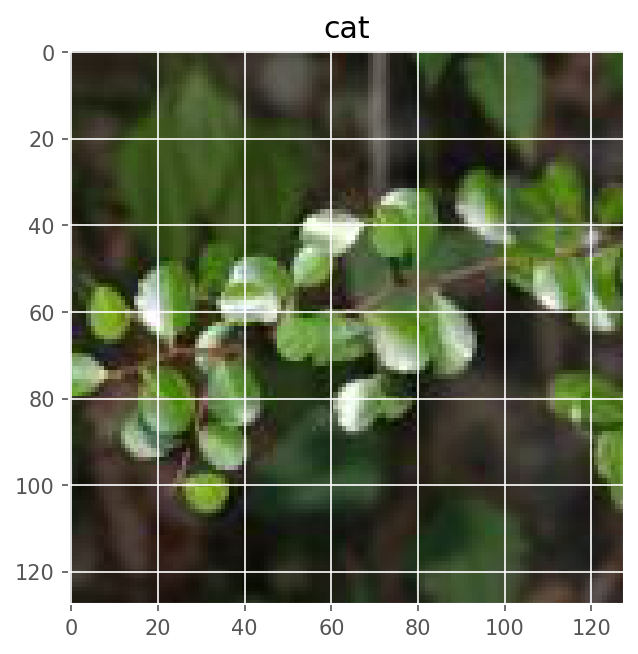

In [96]:
# def Show_Image(Image, Picture_Name):
#     plt.imshow(Image)
#     plt.title(Picture_Name)
#     plt.show()
# train_transform =A.Compose([
#         A.RandomRotate90(),
#         A.Flip(),
#         A.Transpose(),
#         A.GaussNoise(),
#         A.OneOf([
#             A.MotionBlur(p=.2),
#             A.MedianBlur(blur_limit=3, p=0.1),
#             A.Blur(blur_limit=3, p=0.1),
#         ], p=0.2),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#         A.OneOf([
#             A.OpticalDistortion(p=0.3),
#             A.GridDistortion(p=.1),
#         ], p=0.2),
#         A.OneOf([
#             A.CLAHE(clip_limit=2),
#             A.RandomBrightnessContrast(),
#         ], p=0.3),
#         A.HueSaturationValue(p=0.3),
#         A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_LINEAR,p=0.5),
#         A.ToFloat(),
#         A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
#         ToTensorV2(),
#     ])
# img = plt.imread(train_df.iloc[200]["image_path"])
# img2 = train_transform(image = img)["image"]
# Show_Image( img, 'cat')
# Show_Image( img2, 'cat')